In [15]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np



In [16]:
import hytools as ht
import numpy as np

def get_spectral_data_and_wavelengths(filename, row_step, col_step):
    """
    Retrieve spectral data and wavelengths from a specified file using HyTools library.

    Parameters:
    - filename: str, the path to the file to be read.
    - row_step: int, the step size to sample rows by.
    - col_step: int, the step size to sample columns by.

    Returns:
    - original: np.ndarray, a 2D array where each row corresponds to the spectral data from one pixel.
    - wavelengths: np.ndarray, an array containing the wavelengths corresponding to each spectral band.
    """
    # Initialize the HyTools object
    envi = ht.HyTools()
    
    # Read the file using the specified format
    envi.read_file(filename, 'envi')
    
    # Define the row and column ranges
    rowrange = np.arange(0, round(envi.lines, -3), row_step).tolist()  # Adjusted to use envi.lines for dynamic range
    colrange = np.arange(0, round(envi.columns, -3), col_step).tolist()  # Adjusted to use envi.columns for dynamic range
    
    # Retrieve the pixels' spectral data
    original = envi.get_pixels(rowrange, colrange)

    #original = pd.DataFrame(envi.get_pixels(rowrange, colrange))
    #original['index'] = np.arange(original.shape[0])
    
    # Also retrieve the wavelengths
    wavelengths = envi.wavelengths
    
    return original, wavelengths

#filename="export/ENVI__corrected_0"
#filename =  "export/resample_landsat5"
#spectral_data, wavelengths = get_spectral_data_and_wavelengths(filename, row_step, col_step)
#pd.DataFrame(spectral_data)
#wavelengths

In [17]:
import hytools as ht
import numpy as np

def load_spectra(filenames, row_step=6, col_step=1):
    results = {}
    for filename in filenames:
        try:
            spectral_data, wavelengths = get_spectral_data_and_wavelengths(filename, row_step, col_step)
            results[filename] = {"spectral_data": spectral_data, "wavelengths": wavelengths}
        except TypeError:
            print(f"Error processing file: {filename}")
    return results

# Define your list of filenames
filenames = [
    "export/resample_landsat5.img",
    "export/resample_landsat7.img",
    "export/resample_landsat8.img",
    "export/resample_landsat9.img",
    "export/ENVI__corrected_0",
    "output/ENVI"
]

# Usage
spectra = load_spectra(filenames)
#spectra

In [18]:
import pandas as pd

def prepare_spectral_data(spectral_data, wavelengths):
    # Transpose and melt the spectral data to long format
    long_df = pd.melt(pd.DataFrame(spectral_data).transpose(), var_name="band", value_name="reflectance")
    
    # Create a DataFrame for wavelengths and assign a 'band' column based on index
    waves = pd.DataFrame(wavelengths, columns=["wavelength_nm"])
    waves['band'] = range(len(waves))
    
    # Merge the spectral data with wavelengths using the 'band' column
    merged_data = pd.merge(long_df, waves, on='band')
    
    # Convert 'wavelength_nm' to numeric, if necessary
    merged_data["wavelength_nm"] = pd.to_numeric(merged_data["wavelength_nm"])
    
    return merged_data

# Example usage
spectral_data_corrected = np.random.rand(10, 426)  # Example spectral data
full_wavelengths = np.linspace(400, 2500, 426)  # Example wavelength range
prepared_data = prepare_spectral_data(spectral_data_corrected, full_wavelengths)
print(prepared_data)


      band  reflectance  wavelength_nm
0        0     0.681590     400.000000
1        0     0.546648     400.000000
2        0     0.392241     400.000000
3        0     0.962163     400.000000
4        0     0.814455     400.000000
...    ...          ...            ...
4255     9     0.876027     444.470588
4256     9     0.300817     444.470588
4257     9     0.640819     444.470588
4258     9     0.895051     444.470588
4259     9     0.539591     444.470588

[4260 rows x 3 columns]


In [32]:
def reshape_spectra(results, index):
    keys = list(results.keys())
    if index < 0 or index >= len(keys):
        print("Index out of range")
        return None

    first_key = keys[index]
    spectral_data = results[first_key]['spectral_data']
    wavelengths = results[first_key]['wavelengths']

    if index < 4:
        df_spectral_data = pd.DataFrame(spectral_data, columns=wavelengths.astype(str))
        long_df = pd.melt(df_spectral_data, var_name="wavelength_nm", value_name="reflectance")
        waves = pd.DataFrame(wavelengths, columns=["wavelength_nm"])
        waves['band'] = range(len(waves))
        long_df["wavelength_nm"] = pd.to_numeric(long_df["wavelength_nm"])
        merged_data = pd.merge(long_df, waves, on='wavelength_nm')
        # Add a label column to the merged data
        first_key = keys[index].replace("export/resample_", "").replace(".img", "")  # Modified here to remove "export/"
        merged_data['sensor'] = first_key
        merged_data = merged_data.reindex(columns=['sensor', 'band', 'wavelength_nm', 'reflectance','pixel'])
        
        length = len(merged_data)
        sequence = np.arange(0, 1000)  # Creates an array [1, 2, ..., 999]
        repeated_sequence = np.resize(sequence, length)  # Resize the sequence to match the DataFrame's length

        merged_data['pixel'] = repeated_sequence  # Add the column to your DataFrame
        merged_data['sensor_band'] = merged_data['sensor'].astype(str) + '_' + merged_data['band'].astype(str)
        return merged_data
    else:
        merged_data = prepare_spectral_data(spectral_data, wavelengths)
        # Add a label column to the merged data
        first_key = keys[index].replace("export/ENVI__corrected_0", "hyperspectral_corrected")
        first_key = first_key.replace("output/ENVI", "hyperspectral_original")
        merged_data['sensor'] = first_key
        merged_data = merged_data.reindex(columns=['sensor', 'band', 'wavelength_nm', 'reflectance','pixel'])
        length = len(merged_data)
        sequence = np.arange(0, 1000)  # Creates an array [1, 2, ..., 999]
        repeated_sequence = np.resize(sequence, length)  # Resize the sequence to match the DataFrame's length

        merged_data['pixel'] = repeated_sequence  # Add the column to your DataFrame
        merged_data['sensor_band'] = merged_data['sensor'].astype(str) + '_' + merged_data['band'].astype(str)
        return merged_data

sensor = 4  #0,1,2,3,4,5
reshaped_spectra = reshape_spectra(spectra, sensor)
reshaped_spectra

,sensor,band,wavelength_nm,reflectance,pixel,sensor_band
0,hyperspectral_corrected,0,381.273010,-9999.0,0,hyperspectral_corrected_0
1,hyperspectral_corrected,0,381.273010,-9999.0,1,hyperspectral_corrected_0
2,hyperspectral_corrected,0,381.273010,-9999.0,2,hyperspectral_corrected_0
3,hyperspectral_corrected,0,381.273010,-9999.0,3,hyperspectral_corrected_0
4,hyperspectral_corrected,0,381.273010,-9999.0,4,hyperspectral_corrected_0
...,...,...,...,...,...,...
425995,hyperspectral_corrected,425,2509.728027,-9999.0,995,hyperspectral_corrected_425
425996,hyperspectral_corrected,425,2509.728027,-9999.0,996,hyperspectral_corrected_425
425997,hyperspectral_corrected,425,2509.728027,-9999.0,997,hyperspectral_corrected_425
425998,hyperspectral_corrected,425,2509.728027,-9999.0,998,hyperspectral_corrected_425


In [33]:
def concatenate_sensors(reshape_spectra_function, spectra, sensors_range):
    all_spectra = []
    for sensor in sensors_range:  # Typically range(6) for sensors 0 to 5
        reshaped_spectra = reshape_spectra_function(spectra, sensor)
        all_spectra.append(reshaped_spectra)
    
    # Concatenate all reshaped spectra DataFrames into one, preserving columns
    concatenated_spectra = pd.concat(all_spectra, ignore_index=True)
    return concatenated_spectra

# Example usage
sensors_range = range(6)  # Assuming sensors 0 to 5
concatenated_sensors = concatenate_sensors(reshape_spectra, spectra, sensors_range)
concatenated_sensors


,sensor,band,wavelength_nm,reflectance,pixel,sensor_band
0,landsat5,0,485.000000,-9998.999998,0,landsat5_0
1,landsat5,0,485.000000,-9998.999998,1,landsat5_0
2,landsat5,0,485.000000,-9998.999998,2,landsat5_0
3,landsat5,0,485.000000,-9998.999998,3,landsat5_0
4,landsat5,0,485.000000,-9998.999998,4,landsat5_0
...,...,...,...,...,...,...
875995,hyperspectral_original,425,2509.728027,-9999.000000,995,hyperspectral_original_425
875996,hyperspectral_original,425,2509.728027,-9999.000000,996,hyperspectral_original_425
875997,hyperspectral_original,425,2509.728027,-9999.000000,997,hyperspectral_original_425
875998,hyperspectral_original,425,2509.728027,-9999.000000,998,hyperspectral_original_425


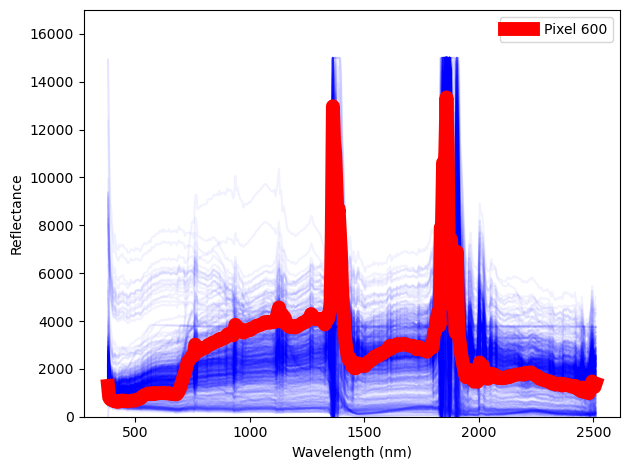

In [34]:
def plot_spectral_data(df, highlight_pixel):
    df = df[df['wavelength_nm'] > 0]  # Exclude negative wavelength_nm values
    df['reflectance'] = df['reflectance'].replace(-9999, np.nan)
    unique_indices = df['pixel'].unique()

    for idx in unique_indices:
        subset = df[df['pixel'] == idx]
        plt.plot(subset['wavelength_nm'], subset['reflectance'], alpha=0.05, color="blue")

    # Highlight a specific pixel
    highlighted_subset = df[df['pixel'] == highlight_pixel]
    # Inside the plot_spectral_data function, after highlighting the specific pixel


    if (highlighted_subset['reflectance'] == -9999).all() or highlighted_subset['reflectance'].isna().all():
        print(f"Warning: Pixel {highlight_pixel} data is entirely -9999 or NaN.")

    plt.plot(highlighted_subset['wavelength_nm'], highlighted_subset['reflectance'], color='red', linewidth=10, label=f'Pixel {highlight_pixel}')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.tight_layout()
    plt.ylim(0, 17000)
    plt.show()



plot_spectral_data(reshaped_spectra, highlight_pixel=600)




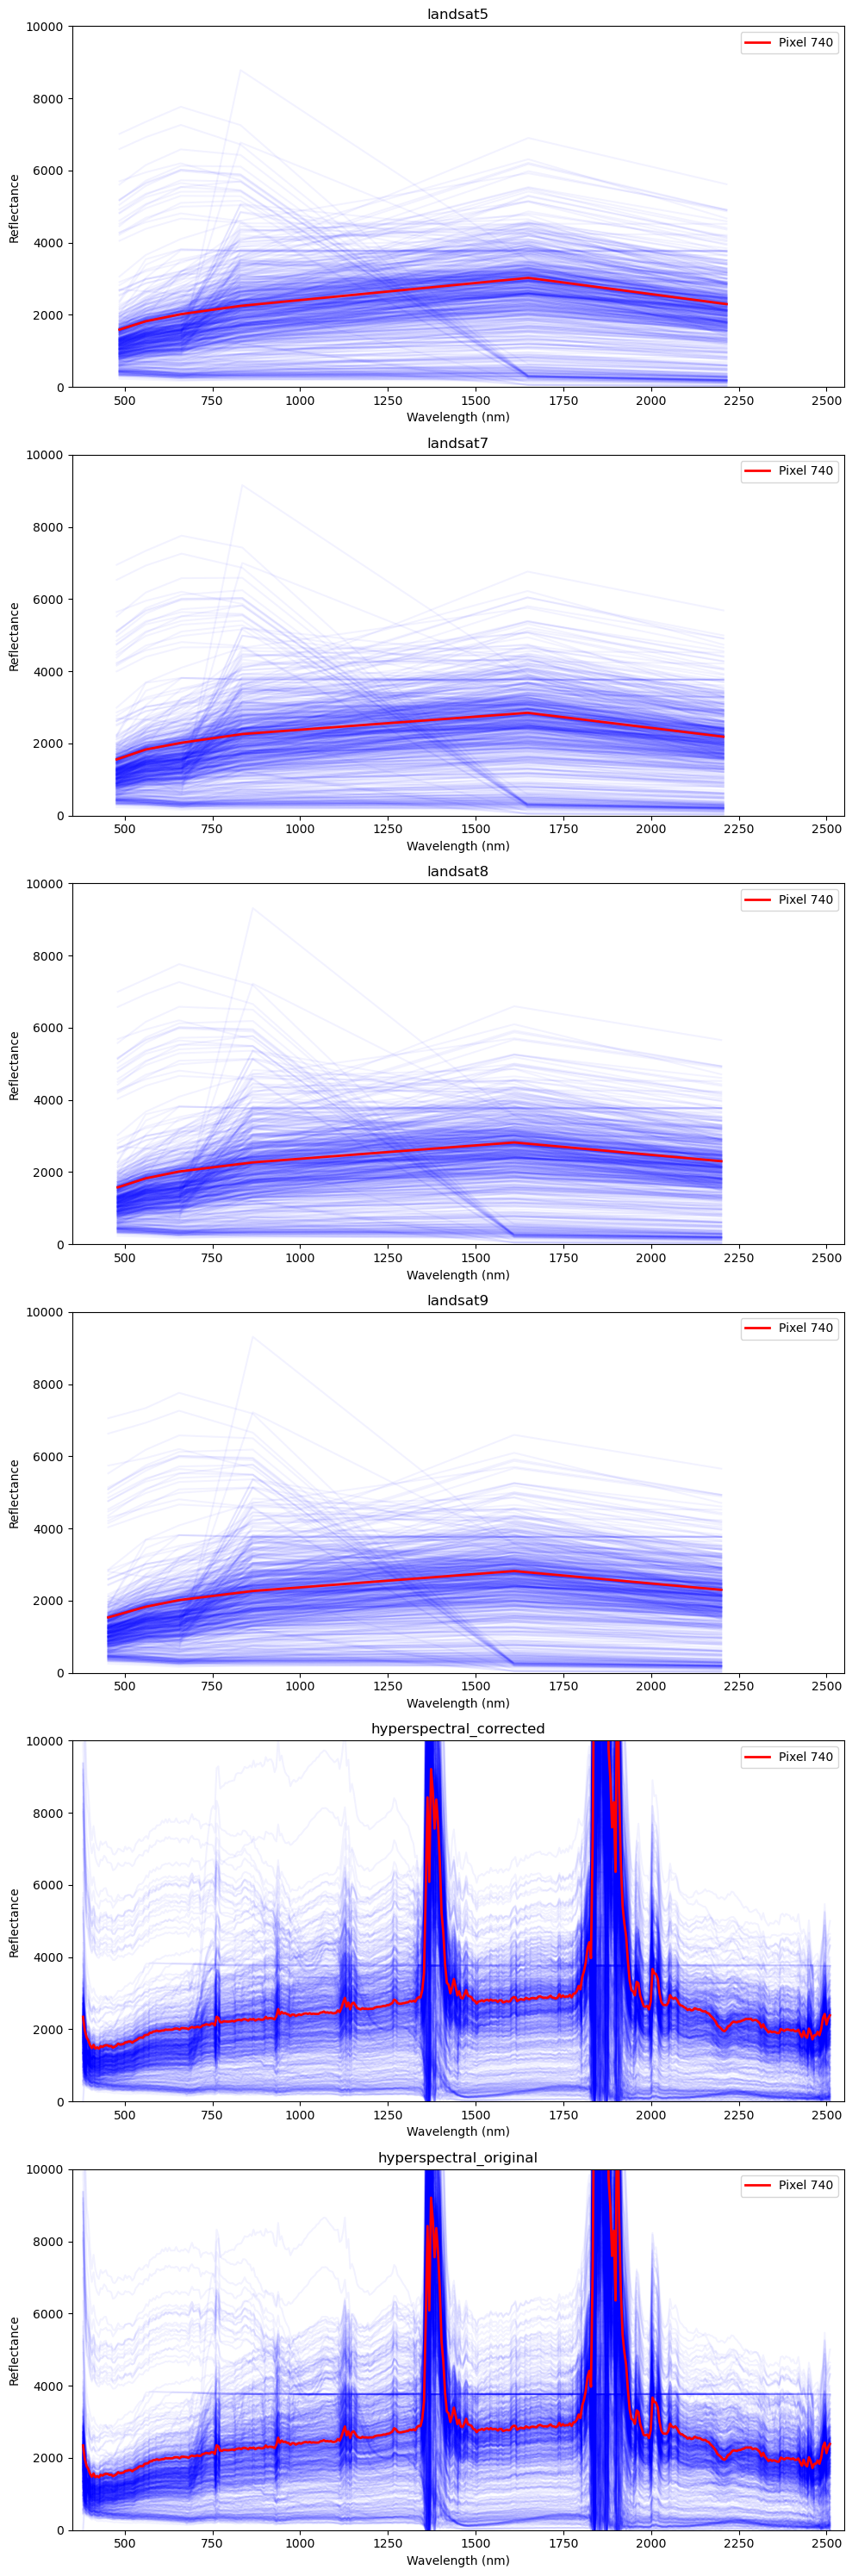

In [35]:
def plot_each_sensor_with_highlight(concatenated_sensors, highlight_pixel, save_path=None):
    sensors = concatenated_sensors['sensor'].unique()
    fig, axs = plt.subplots(len(sensors), 1, figsize=(10, 5 * len(sensors)))
    
    for i, sensor in enumerate(sensors):
        df = concatenated_sensors[concatenated_sensors['sensor'] == sensor]
        pixels = df['pixel'].unique()
        
        for pixel in pixels:
            subset = df[df['pixel'] == pixel]
            axs[i].plot(subset['wavelength_nm'], subset['reflectance'], alpha=0.05, color="blue")
        
        highlighted_subset = df[df['pixel'] == highlight_pixel]
        if not highlighted_subset.empty and not highlighted_subset['reflectance'].isna().all():
            axs[i].plot(highlighted_subset['wavelength_nm'], highlighted_subset['reflectance'], color='red', linewidth=2, label=f'Pixel {highlight_pixel}')
        
        axs[i].set_title(sensor)
        axs[i].set_xlabel('Wavelength (nm)')
        axs[i].set_ylabel('Reflectance')
        axs[i].set_ylim(0, 10000)
        axs[i].set_xlim(350, 2550)
        axs[i].legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format=save_path.split('.')[-1])
    plt.show()



plot_each_sensor_with_highlight(concatenated_sensors , 740, 'figure_740.pdf')


TypeError: 'int' object is not iterable

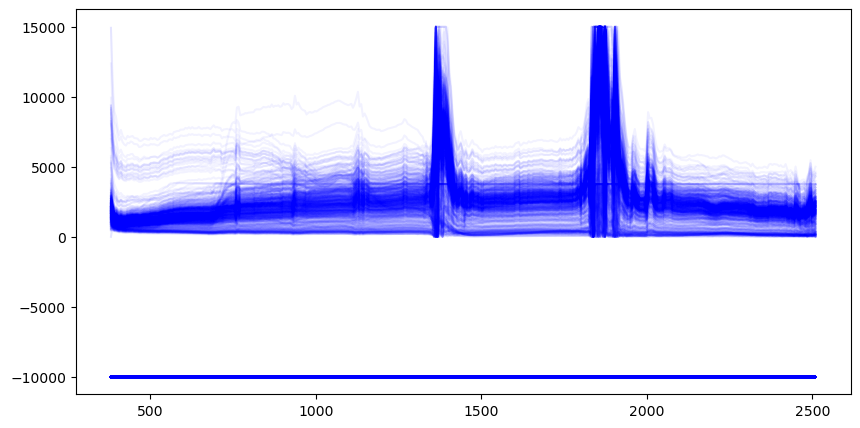

In [37]:
def plot_with_highlighted_sensors(concatenated_sensors, highlight_pixels, save_path=None):
    plt.figure(figsize=(10, 5))
    # Filter to get only hyperspectral corrected data for background
    hyperspectral_corrected = concatenated_sensors[concatenated_sensors['sensor'] == 'hyperspectral_corrected']
    
    # Plotting hyperspectral corrected data in blue
    for pixel in hyperspectral_corrected['pixel'].unique():
        subset = hyperspectral_corrected[hyperspectral_corrected['pixel'] == pixel]
        plt.plot(subset['wavelength_nm'], subset['reflectance'], alpha=0.05, color="blue")
    
    # Overlaying highlighted lines from each sensor in red
    for sensor in concatenated_sensors['sensor'].unique():
        if sensor != 'hyperspectral_corrected':  # Exclude hyperspectral corrected data from red lines
            for highlight_pixel in highlight_pixels:
                highlighted_subset = concatenated_sensors[(concatenated_sensors['pixel'] == highlight_pixel) & (concatenated_sensors['sensor'] == sensor)]
                if not highlighted_subset.empty and not highlighted_subset['reflectance'].isna().all():
                    plt.plot(highlighted_subset['wavelength_nm'], highlighted_subset['reflectance'], color='red', linewidth=2, label=sensor)
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.ylim(0, 10000)
    plt.xlim(350, 2550)
    plt.legend()
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format=save_path.split('.')[-1])
    plt.show()

plot_with_highlighted_sensors(concatenated_sensors , 740, 'figure_740.pdf')
